## Final Project Submission

* Student name: Hoang Nguyen, Madoria Thomas, Marcelo Scatena
* Student pace: full time
* Scheduled project review date: 07/01/2021
* Instructor name: Skyler English


In [1]:
#pip install yellowbrick

In [2]:
#pip install geopy

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from yellowbrick.features import Rank2D
# from ipynb.fs.full.cleaning_data import clean_data
from geopy import distance
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('data/kc_house_data.csv')

In [5]:
df_ref = pd.read_csv('data/kc_house_data.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Split Data into Test and Train

In [7]:
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [8]:
# We'll use df as our train dataset
y = y_train
X_train['price'] = y
df = X_train

### Find out where my missing values and fill them to make a first model with all the information we can:

In [9]:
df.isnull().sum()

id                  0
date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1897
view               53
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3059
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
price               0
dtype: int64

In [10]:
df['view'].value_counts()

NONE         15556
AVERAGE        753
GOOD           395
EXCELLENT      263
FAIR           257
Name: view, dtype: int64

In [11]:
df['view'].fillna('NONE', inplace=True)

In [12]:
df['waterfront'].value_counts()

NO     15262
YES      118
Name: waterfront, dtype: int64

In [13]:
df['waterfront'].fillna('NO', inplace=True)

In [14]:
df['yr_renovated'].value_counts() 

0.0       13625
2014.0       56
2005.0       27
2003.0       24
2007.0       24
          ...  
1954.0        1
1959.0        1
1944.0        1
1951.0        1
1978.0        1
Name: yr_renovated, Length: 68, dtype: int64

In [15]:
df['yr_renovated'].fillna(0.0, inplace=True)

### Change all our objects into numeric values:

In [16]:
# Convert grade to int
df['grade'] = df['grade'].apply(lambda x: x[:2] if x[0]=='1' else x[:1]).astype('int64')

In [17]:
# Remove ? and convert sqft_basement to int
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else int(x.split('.')[0]))

In [18]:
# Change waterfront to numeric
df['waterfront'] = df['waterfront'].apply(lambda x: 1 if x=='YES' else 0)

In [19]:
df['view'].unique()

array(['NONE', 'AVERAGE', 'GOOD', 'EXCELLENT', 'FAIR'], dtype=object)

In [20]:
# Change view to numeric
df['view'] = df['view'].apply(lambda x: 0 if x=='NONE' else (1 if x=='FAIR' else (2 if x=='AVERAGE' else (3 if x=='GOOD' else 4))))

In [21]:
df['condition'].unique()

array(['Good', 'Average', 'Very Good', 'Fair', 'Poor'], dtype=object)

In [22]:
# Change condition to numeric
df['condition'] = df['condition'].apply(lambda x: 1 if x=='Poor' else (2 if x=='Fair' else (3 if x=='Average' else (4 if x=='Good' else 5))))

In [23]:
#Convert date column to 2 separate columns for month and year
date = df['date'].str.split('/', expand=True)
df['month_sold'] = date[0].astype('int64')
df['year_sold'] = date[2].astype('int64')

#Drop original date column
df.drop(columns=['date'], axis=1, inplace=True)

In [24]:
df.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,month_sold,year_sold
6243,9834201100,4,2.00,1440,4855,2.0,0,0,4,7,...,1972,0.0,98144,47.5717,-122.287,1300,4080,332500.0,12,2014
8986,7795810110,3,1.75,1430,9857,1.0,0,2,4,7,...,1980,0.0,98045,47.4964,-121.771,1310,9880,390000.0,5,2015
9419,1853081250,4,2.75,3120,5000,2.0,0,0,3,9,...,2010,0.0,98074,47.5940,-122.062,3200,5000,800000.0,12,2014
10155,2558630350,4,2.50,2060,6958,1.0,0,0,3,7,...,1974,0.0,98034,47.7251,-122.168,1760,7350,462000.0,3,2015
10436,3362401000,3,2.00,2500,4080,1.5,0,0,5,7,...,1922,0.0,98103,47.6813,-122.346,1550,3060,695000.0,7,2014


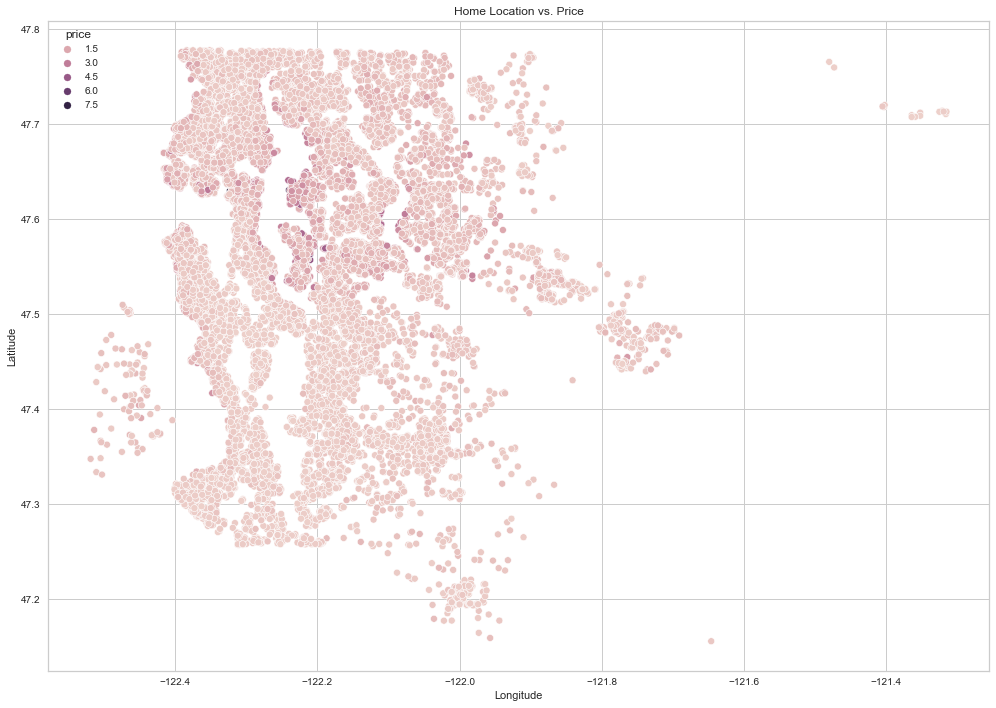

In [25]:
plt.figure(figsize=(14, 10))
plt.title('Home Location vs. Price')
sns.scatterplot(df['long'], df['lat'], hue=df['price'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Model 1 - Using All Features

In [26]:
X = df.drop('price', axis=1)
y = df['price']
model_1 = sm.OLS(y, sm.add_constant(X)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     1946.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:25:40   Log-Likelihood:            -2.3549e+05
No. Observations:               17277   AIC:                         4.710e+05
Df Residuals:                   17255   BIC:                         4.712e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.024e+07   1.11e+07     -6.316      0.000    -9.2e+07   -4.84e+07
id            -1.756e-06   5.38e-07     -3.262      0.001   -2.81e-06   -7.01e-07
bedrooms      -3.898e+04   2208.241    -17.652      0.000   -4.33e+04   -3.47e+04
bathrooms      4.258e+04   3669.369     11.605      0.000    3.54e+04    4.98e+04
sqft_living     101.3979     21.483      4.720      0.000      59.289     143.507
sqft_lot          0.0878      0.055      1.606      0.108      -0.019       0.195
floors         9946.9534   4024.590      2.472      0.013    2058.348    1.78e+04
waterfront     6.041e+05   2.02e+04     29.925      0.000    5.65e+05    6.44e+05
view           5.253e+04   2374.225     22.125      0.000    4.79e+04    5.72e+04
condition       2.98e+04   2626.080     11.347      0.000    2.47e+04    3.49e+04
grade          9.905e+04   2415.860     41.002      0.000    9.43e+04    1.04e+05
sqft_above       78.2646     21.420      3.654      0.000      36.279     120.250
sqft_basement    52.3378     21.253      2.463      0.014      10.679      93.996
yr_built      -2696.8508     80.408    -33.540      0.000   -2854.459   -2539.243
yr_renovated     22.9471      4.454      5.152      0.000      14.217      31.678
zipcode        -564.7472     36.869    -15.318      0.000    -637.014    -492.480
lat            5.897e+05    1.2e+04     49.016      0.000    5.66e+05    6.13e+05
long          -2.078e+05   1.46e+04    -14.210      0.000   -2.36e+05   -1.79e+05
sqft_living15    24.7295      3.883      6.369      0.000      17.119      32.340
sqft_lot15       -0.4617      0.082     -5.631      0.000      -0.622      -0.301
month_sold     1435.9748    789.356      1.819      0.069    -111.243    2983.192
year_sold      3.812e+04   5268.577      7.235      0.000    2.78e+04    4.84e+04
==============================================================================
Omnibus:                    14849.799   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1493773.020
Skew:                           3.630   Prob(JB):                         0.00
Kurtosis:                      47.970   Cond. No.                     3.94e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
def clean_data_model_1(df):
    # Fill NaN values with most commom occurances
    df['view'].fillna('NONE', inplace=True)
    df['waterfront'].fillna('NO', inplace=True)
    df['yr_renovated'].fillna(0.0, inplace=True)
    # Convert grade to int
    df['grade'] = df['grade'].apply(lambda x: x[:2] if x[0]=='1' else x[:1]).astype('int64')
    # Remove ? and convert sqft_basement to int
    df['sqft_basement'] = df['sqft_basement'].apply(lambda x: 0 if x=='?' else int(x.split('.')[0]))
    # Change waterfront to numeric
    df['waterfront'] = df['waterfront'].apply(lambda x: 1 if x=='YES' else 0)
    # Change view to numeric
    df['view'] = df['view'].apply(lambda x: 0 if x=='NONE' else (1 if x=='FAIR' else (2 if x=='AVERAGE' else (3 if x=='GOOD' else 4))))
    # Change condition to numeric
    df['condition'] = df['condition'].apply(lambda x: 1 if x=='Poor' else (2 if x=='Fair' else (3 if x=='Average' else (4 if x=='Good' else 5))))
    #Convert date column to 2 separate columns for month and year
    date = df['date'].str.split('/', expand=True)
    df['month_sold'] = date[0].astype('int64')
    df['year_sold'] = date[2].astype('int64')
    #Drop original date column
    df.drop(columns=['date'], axis=1, inplace=True)
    
    return df

In [28]:
LR = LinearRegression()
LR.fit(X,y)

LinearRegression()

In [29]:
to_clean = X_test
X_test['price'] = y_test

In [30]:
# Clean test according to cahnges so far
cleaned_X_test_1 = clean_data_model_1(to_clean)

In [31]:
y_test = cleaned_X_test_1['price']
X_test = cleaned_X_test_1.drop('price', axis=1)

In [32]:
y_prediction =  LR.predict(X_test)
y_prediction

array([ 95465.40946388, 380892.32744578, 217276.84544568, ...,
       490317.90520094, 338029.81792317, 229569.37989503])

In [33]:
rms_1 = mean_squared_error(y_test, y_prediction, squared=False)

In [34]:
rms_1

199177.32750300207

In [35]:
r_squared_1 = model_1.rsquared
r_squared_1

0.7030858756443649

In [36]:
LR.score(X_test, y_test) #r-squared of test data

0.695340645910875

In [37]:
df_2 = df.copy()

# Checking our Assumptions

## Normality

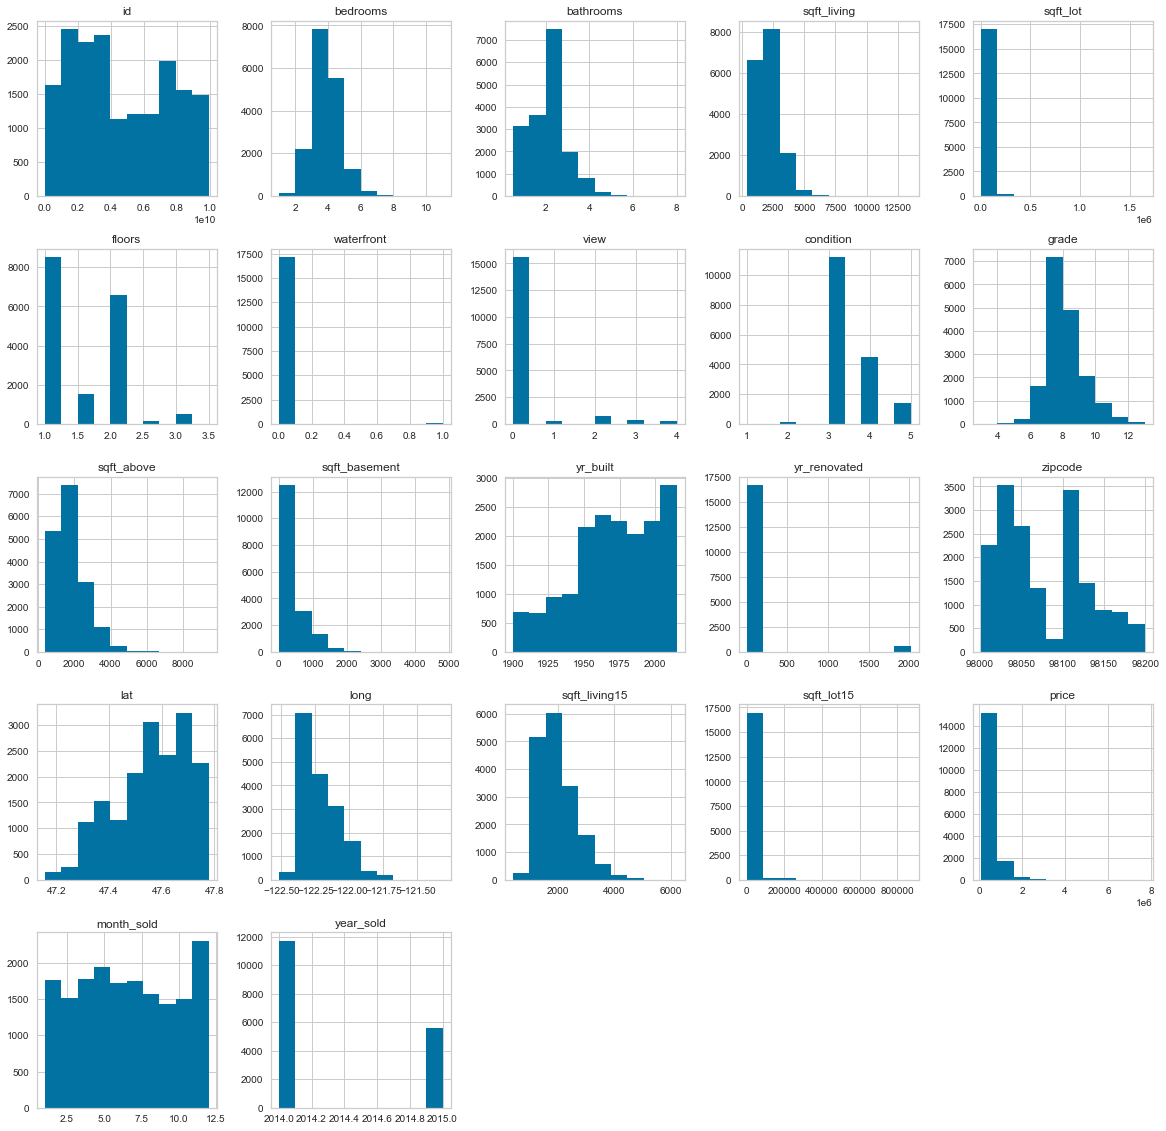

In [38]:
df_2.hist(figsize=(20,20));

None of these variables seem to follow a normal distribution. While this may create problems satisfying all assumptions, we'll first take a look at the other assumptions to see if there are any obvious changes to me made.

For now we'll use a QQ Plot to confirm that our assesment is correct.

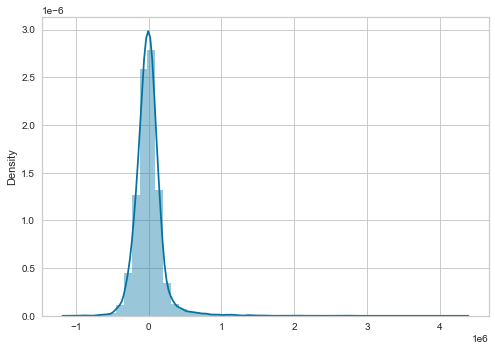

In [39]:
sns.distplot(model_1.resid);

<Figure size 864x576 with 0 Axes>

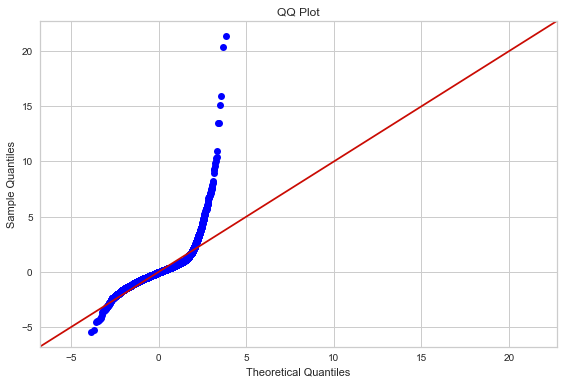

In [40]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model_1.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

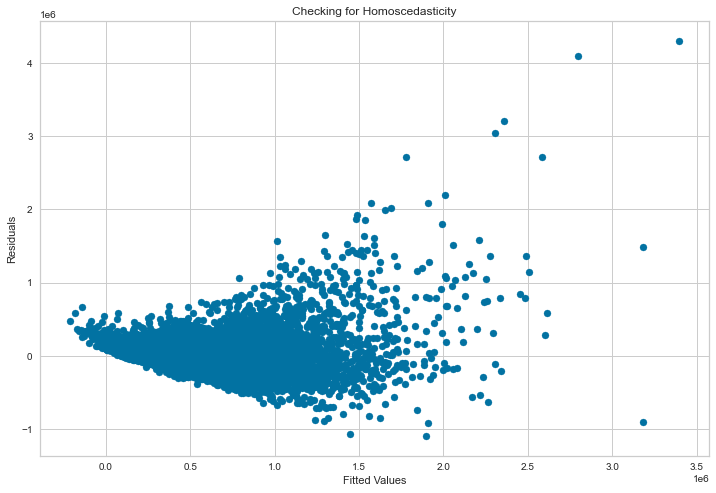

In [41]:
plt.figure(figsize=(12, 8))
plt.scatter(model_1.predict(), model_1.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity');

# MODEL 2 - EDA and dealing with some outliers

In [42]:
df_2['bedrooms'].value_counts()

3     7836
4     5542
2     2189
5     1281
6      216
1      161
7       35
8       10
9        4
10       2
11       1
Name: bedrooms, dtype: int64

In [43]:
# Remove the few houses with high number of bedrooms
df_2 = df_2[~df_2['bedrooms'].isin([11, 10, 9])]

#### Turn Bathrooms column into wc_comp and wc_inc:

In [44]:
df_2['bathrooms'].value_counts()

2.50    4322
1.00    3076
1.75    2446
2.25    1646
2.00    1526
1.50    1168
2.75     933
3.00     593
3.50     583
3.25     465
3.75     120
4.00     111
4.50      82
4.25      66
0.75      59
4.75      20
5.00      17
5.25       9
1.25       5
5.50       5
0.50       4
5.75       3
6.00       3
6.50       2
8.00       2
6.75       2
6.25       1
7.75       1
Name: bathrooms, dtype: int64

In [45]:
df_2['bathrooms'] = df_2['bathrooms'].apply(lambda x: np.ceil(x) if str(x)[2] == '7' else (np.ceil(x) if str(x)[2] == '5' else np.floor(x)))

In [46]:
df_2['bathrooms'].value_counts()

2.0    6786
3.0    6313
1.0    3144
4.0     880
5.0     128
6.0      12
7.0       4
8.0       3
Name: bathrooms, dtype: int64

In [47]:
df_2 = df_2[~df_2['bathrooms'].isin([8.0, 7.0])]

#### Changed Floor column:

In [48]:
df_2['floors'].value_counts()

1.0    8530
2.0    6571
1.5    1532
3.0     498
2.5     125
3.5       7
Name: floors, dtype: int64

In [49]:
df_2 = df_2[df_2['long'] < -121.647]

# Model 2 - Changing features and removing outliers

In [50]:
X = df_2.drop('price', axis=1)
y = df_2['price']
model_2 = sm.OLS(y, sm.add_constant(X)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     1952.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:25:45   Log-Likelihood:            -2.3462e+05
No. Observations:               17247   AIC:                         4.693e+05
Df Residuals:                   17225   BIC:                         4.695e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.077e+07   1.08e+07     -6.529      0.000    -9.2e+07   -4.95e+07
id            -1.973e-06   5.25e-07     -3.759      0.000      -3e-06   -9.44e-07
bedrooms      -3.257e+04   2174.335    -14.978      0.000   -3.68e+04   -2.83e+04
bathrooms      1.213e+04   3018.351      4.020      0.000    6217.734    1.81e+04
sqft_living     113.4304     20.891      5.430      0.000      72.482     154.379
sqft_lot          0.1115      0.053      2.095      0.036       0.007       0.216
floors         2.139e+04   3922.480      5.454      0.000    1.37e+04    2.91e+04
waterfront     6.044e+05   1.97e+04     30.630      0.000    5.66e+05    6.43e+05
view           5.149e+04   2315.869     22.235      0.000     4.7e+04     5.6e+04
condition      3.147e+04   2558.014     12.303      0.000    2.65e+04    3.65e+04
grade          1.025e+05   2356.697     43.493      0.000    9.79e+04    1.07e+05
sqft_above       62.5650     20.856      3.000      0.003      21.685     103.445
sqft_basement    47.3958     20.698      2.290      0.022       6.826      87.966
yr_built      -2484.7905     78.798    -31.534      0.000   -2639.243   -2330.338
yr_renovated     24.2116      4.341      5.577      0.000      15.702      32.721
zipcode        -558.4409     35.935    -15.540      0.000    -628.877    -488.005
lat            5.927e+05   1.17e+04     50.551      0.000     5.7e+05    6.16e+05
long          -2.057e+05   1.46e+04    -14.085      0.000   -2.34e+05   -1.77e+05
sqft_living15    30.5314      3.815      8.004      0.000      23.054      38.009
sqft_lot15       -0.4547      0.080     -5.691      0.000      -0.611      -0.298
month_sold     1307.0456    769.295      1.699      0.089    -200.852    2814.943
year_sold      3.791e+04   5134.739      7.384      0.000    2.79e+04     4.8e+04
==============================================================================
Omnibus:                    12470.532   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           568493.071
Skew:                           2.981   Prob(JB):                         0.00
Kurtosis:                      30.487   Cond. No.                     3.94e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
def clean_data_model_2(df):
    
    df = df[~df['bedrooms'].isin([11, 10, 9])]
    df['bathrooms'] = df['bathrooms'].apply(lambda x: np.ceil(x) if str(x)[2] == '7' else (np.ceil(x) if str(x)[2] == '5' else np.floor(x)))
    df = df[~df['bathrooms'].isin([8.0, 7.0])]
    df['floors'] = df['floors'].apply(lambda x: np.ceil(x))
    df = df[df['long'] < -121.647]
    
    return df

In [52]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_2 = clean_data_model_2(to_clean)

y_test = cleaned_X_test_2['price']
X_test = cleaned_X_test_2.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms_2 = mean_squared_error(y_test, y_prediction, squared=False)
rms_2

199853.535668498

In [53]:
r_squared_2 = model_2.rsquared
r_squared_2

0.7041499253725569

In [54]:
LR.score(X_test, y_test) #r-squared of test data

0.6931221431444159

In [55]:
df_3 = df_2.copy()

# MODEL 3 - Variable Correlations

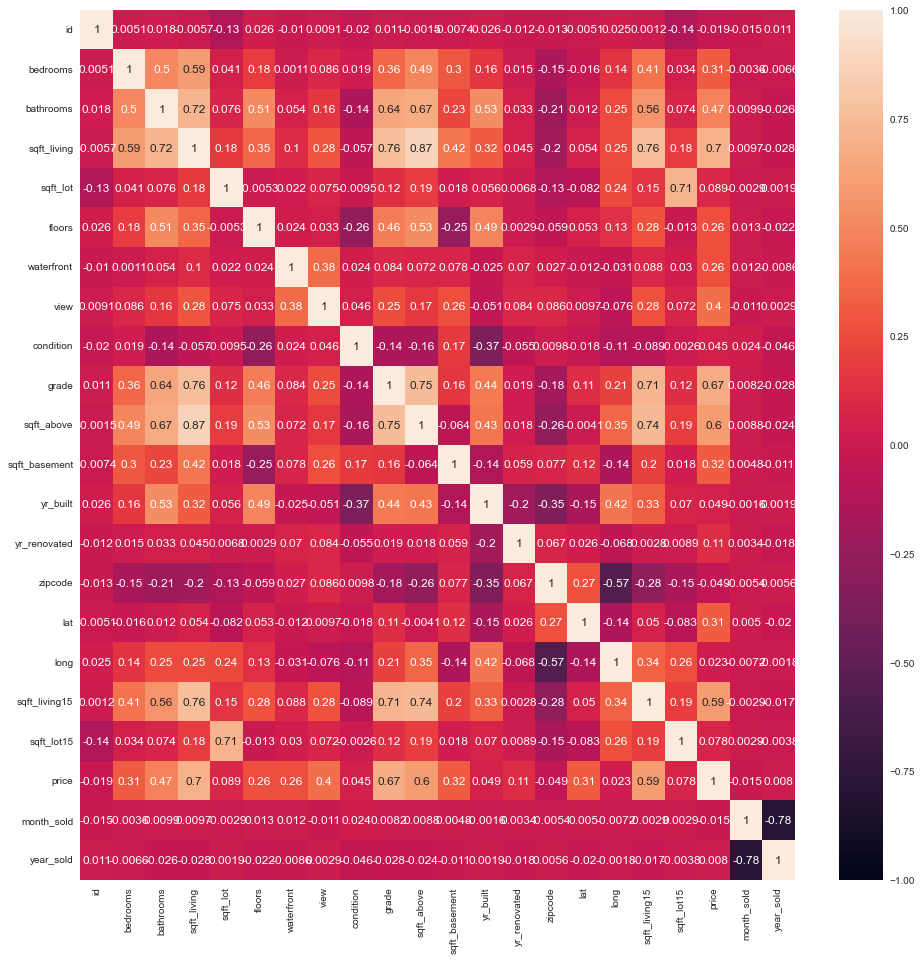

In [56]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(df_3.corr(), vmin=-1, vmax=1, annot=True);

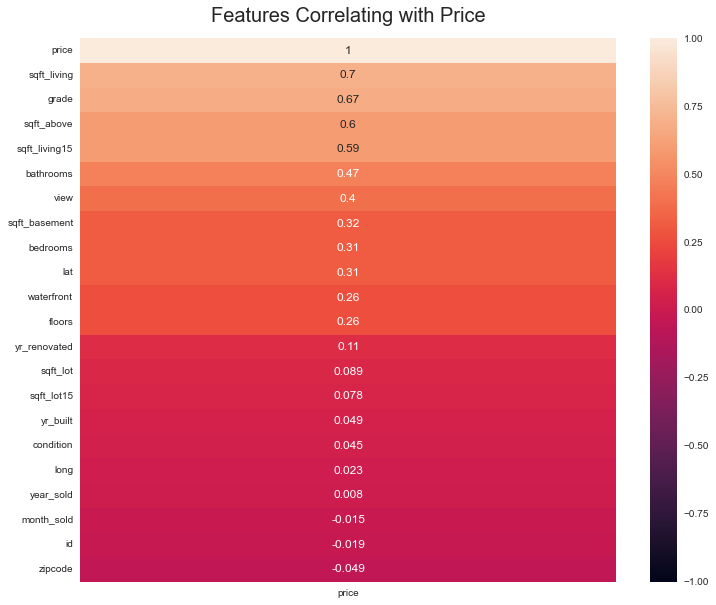

In [57]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df_3.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

Of the features most correlated with Price, a few of them are regarding to the size of the property and surrounding ones (sqft_living, sqft_living15, sqft_above, number of bathrooms)

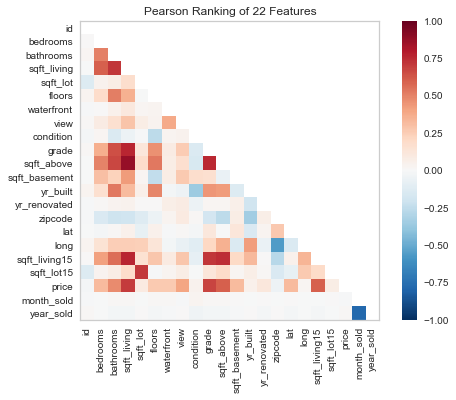

In [58]:
visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(df_3)
visualizer.show();

In [59]:
# Drop some highly correlated columns
df_3.drop(['grade', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

In [60]:
# Drop uncorrelated columns
df_3.drop(['id', 'year_sold', 'month_sold', 'zipcode'], axis=1, inplace=True)

# Model 3 - Addressing multicolinearity

In [61]:
X = df_3.drop('price', axis=1)
y = df_3['price']
model_3 = sm.OLS(y, sm.add_constant(X)).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2516.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:25:48   Log-Likelihood:            -2.3595e+05
No. Observations:               17247   AIC:                         4.719e+05
Df Residuals:                   17233   BIC:                         4.720e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -4.7e+07   1.82e+06    -25.819      0.000   -5.06e+07   -4.34e+07
bedrooms      -4.627e+04   2315.546    -19.983      0.000   -5.08e+04   -4.17e+04
bathrooms       2.11e+04   3248.581      6.494      0.000    1.47e+04    2.75e+04
sqft_living     294.5901      3.192     92.289      0.000     288.333     300.847
sqft_lot         -0.1126      0.042     -2.667      0.008      -0.195      -0.030
floors         2.457e+04   4150.570      5.920      0.000    1.64e+04    3.27e+04
waterfront     5.752e+05   2.13e+04     27.027      0.000    5.34e+05    6.17e+05
view             6.6e+04   2438.646     27.063      0.000    6.12e+04    7.08e+04
condition      3.592e+04   2738.679     13.115      0.000    3.05e+04    4.13e+04
sqft_basement   -63.6823      4.944    -12.881      0.000     -73.373     -53.991
yr_built      -1464.2716     82.097    -17.836      0.000   -1625.190   -1303.353
yr_renovated     29.9567      4.679      6.403      0.000      20.786      39.127
lat            6.537e+05   1.22e+04     53.775      0.000     6.3e+05    6.77e+05
long          -1.528e+05   1.38e+04    -11.083      0.000    -1.8e+05   -1.26e+05
==============================================================================
Omnibus:                    11079.032   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           349870.654
Skew:                           2.603   Prob(JB):                         0.00
Kurtosis:                      24.442   Cond. No.                     4.84e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
def clean_data_model_3(df):
    df.drop(['grade', 'sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
    df.drop(['id', 'year_sold', 'month_sold', 'zipcode'], axis=1, inplace=True)
    return df

In [63]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_3 = clean_data_model_3(to_clean)

y_test = cleaned_X_test_3['price']
X_test = cleaned_X_test_3.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms_3 = mean_squared_error(y_test, y_prediction, squared=False)
rms_3

211866.52008641203

In [64]:
r_squared_3 = model_3.rsquared
r_squared_3

0.6548993176810017

In [65]:
LR.score(X_test, y_test) #r-squared of test data

0.6551211613341577

In [66]:
df_4 = df_3.copy()

## MODEL 4 - Feature Engineering

In [67]:
def distance_from(lat, long, series_lat, series_long):
    lat_long = series_lat.astype(str) + ',' + series_long.astype(str)
    lat_long = list(map(eval, lat_long))
    coordinates = (lat, long)
    miles = []
    for i in lat_long:
        miles.append(round(distance.distance(i, coordinates).miles, 1))
    series = pd.DataFrame(miles)
    return series

In [68]:
# df['distance_seattle'] = distance_from(47.6062, -122.3321, df['lat'], df['long'])
# df['distance_redmond'] = distance_from(47.6740, -122.1215, df['lat'], df['long'])

In [69]:
lat_long = df_4['lat'].astype(str) + ',' + df_4['long'].astype(str)
lat_long = list(map(eval, lat_long))
Seattle = (47.6062, -122.3321)
Redmond = (47.6740, -122.1215)
Kent = (47.3809, -122.2348)
miles_s = []
miles_r = []
miles_k = []
for i in lat_long:
    miles_s.append(round(distance.distance(i, Seattle).miles, 1))
    miles_r.append(round(distance.distance(i, Redmond).miles, 1))
    miles_k.append(round(distance.distance(i, Kent).miles, 1))
df_4['distance_seattle'] = miles_s
df_4['distance_redmond'] = miles_r
df_4['distance_kent'] = miles_k

Since we created new columns using location information, we can drop the latitude, longitude and zipcode columns.

In [70]:
df_4.drop(['lat', 'long'], axis=1, inplace=True)

In [71]:
# Create column with rencent builds
df_4['recent_build'] = df_4['yr_built'].apply(lambda x: 1 if x > 2010 else 0)

In [72]:
df_4.drop(['yr_built'], axis=1, inplace=True)

# Model 4 - With Feature Engineering Done

In [73]:
X = df_4.drop('price', axis=1)
y = df_4['price']
model_4 = sm.OLS(y, sm.add_constant(X)).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2832.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:25:59   Log-Likelihood:            -2.3483e+05
No. Observations:               17247   AIC:                         4.697e+05
Df Residuals:                   17232   BIC:                         4.698e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3.687e+04   1.39e+04      2.648      0.008    9577.888    6.42e+04
bedrooms             -4e+04   2162.893    -18.495      0.000   -4.42e+04   -3.58e+04
bathrooms         9764.9929   2851.511      3.424      0.001    4175.741    1.54e+04
sqft_living        301.0820      3.028     99.442      0.000     295.147     307.017
sqft_lot             0.1804      0.040      4.516      0.000       0.102       0.259
floors           -2.209e+04   3894.357     -5.673      0.000   -2.97e+04   -1.45e+04
waterfront        5.978e+05      2e+04     29.940      0.000    5.59e+05    6.37e+05
view              6.416e+04   2292.623     27.986      0.000    5.97e+04    6.87e+04
condition         4.541e+04   2450.394     18.533      0.000    4.06e+04    5.02e+04
sqft_basement      -99.5991      4.720    -21.103      0.000    -108.850     -90.348
yr_renovated        42.0076      4.224      9.945      0.000      33.728      50.287
distance_seattle -1.651e+04    340.359    -48.513      0.000   -1.72e+04   -1.58e+04
distance_redmond -2367.6622    386.776     -6.122      0.000   -3125.782   -1609.543
distance_kent     5844.2652    294.349     19.855      0.000    5267.312    6421.218
recent_build      2.395e+04   7215.055      3.320      0.001    9811.071    3.81e+04
==============================================================================
Omnibus:                    11699.979   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           442794.187
Skew:                           2.762   Prob(JB):                         0.00
Kurtosis:                      27.200   Cond. No.                     5.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
def clean_data_model_4(df):
    
    lat_long = df['lat'].astype(str) + ',' + df['long'].astype(str)
    lat_long = list(map(eval, lat_long))
    Seattle = (47.6062, -122.3321)
    Redmond = (47.6740, -122.1215)
    Kent = (47.3809, -122.2348)
    miles_s = []
    miles_r = []
    miles_k = []
    for i in lat_long:
        miles_s.append(round(distance.distance(i, Seattle).miles, 1))
        miles_r.append(round(distance.distance(i, Redmond).miles, 1))
        miles_k.append(round(distance.distance(i, Kent).miles, 1))
    df['distance_seattle'] = miles_s
    df['distance_redmond'] = miles_r
    df['distance_kent'] = miles_k
    
    df.drop(['lat', 'long'], axis=1, inplace=True)
    df['recent_build'] = df['yr_built'].apply(lambda x: 1 if x > 2010 else 0)
    df.drop(['yr_built'], axis=1, inplace=True)
    
    return df

In [75]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_4 = clean_data_model_4(to_clean)

y_test = cleaned_X_test_4['price']
X_test = cleaned_X_test_4.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms_4 = mean_squared_error(y_test, y_prediction, squared=False)
rms_4

198376.8405914581

In [76]:
r_squared_4 = model_4.rsquared
r_squared_4

0.6970492100796803

In [77]:
LR.score(X_test, y_test) #r-squared of test data

0.6976403602129961

In [78]:
df_5 = df_4.copy()

## MODEL 5 - Extended EDA

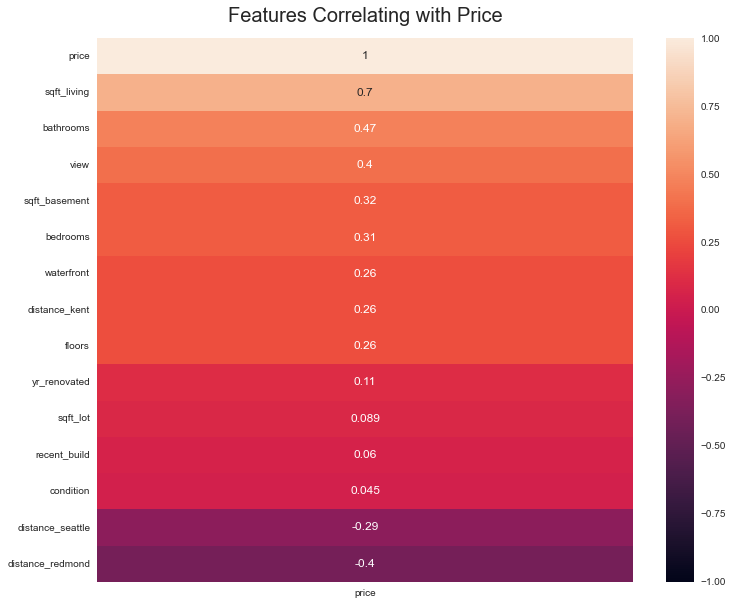

In [79]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df_5.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

In [80]:
# Drop some highly correlated columns or with near zero correlation with price
df_5.drop(['condition', 'sqft_lot', 'yr_renovated', 'bathrooms', 'recent_build'], axis=1, inplace=True)

In [81]:
# Drop outlier
df_5 = df_5[df_5['price'] < 5000000]
df_5 = df_5[df_5['sqft_basement'] < 3000]

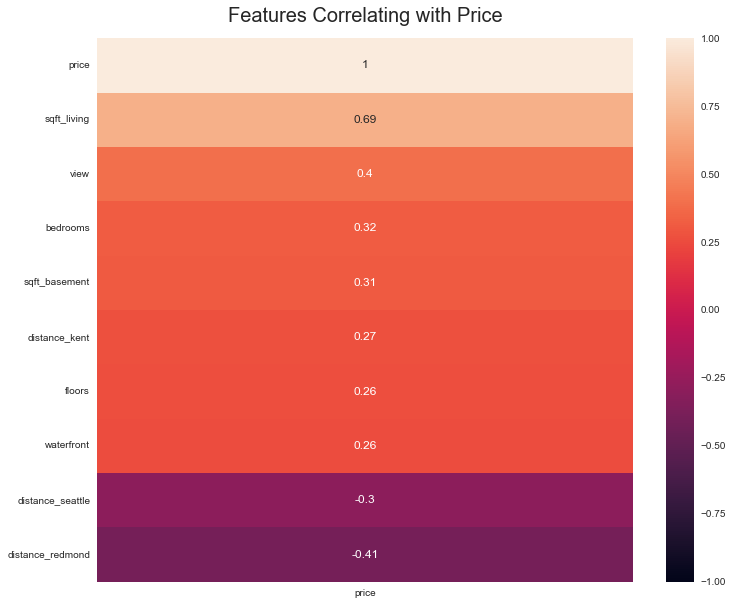

In [82]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df_5.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

## Model 5

In [83]:
X = df_5.drop('price', axis=1)
y = df_5['price']
model_5 = sm.OLS(y, sm.add_constant(X)).fit()
model_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     4257.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        09:26:03   Log-Likelihood:            -2.3467e+05
No. Observations:               17243   AIC:                         4.694e+05
Df Residuals:                   17233   BIC:                         4.694e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.041e+05   1.05e+04     19.483      0.000    1.84e+05    2.25e+05
bedrooms         -3.548e+04   2118.421    -16.750      0.000   -3.96e+04   -3.13e+04
sqft_living        301.8621      2.704    111.637      0.000     296.562     307.162
floors           -2.753e+04   3451.467     -7.977      0.000   -3.43e+04   -2.08e+04
waterfront        5.808e+05      2e+04     29.045      0.000    5.42e+05     6.2e+05
view              6.795e+04   2279.099     29.813      0.000    6.35e+04    7.24e+04
sqft_basement      -94.4463      4.640    -20.356      0.000    -103.541     -85.352
distance_seattle -1.666e+04    327.651    -50.854      0.000   -1.73e+04    -1.6e+04
distance_redmond -1997.6733    381.599     -5.235      0.000   -2745.647   -1249.700
distance_kent     6000.8783    290.998     20.622      0.000    5430.493    6571.263
==============================================================================
Omnibus:                    10138.038   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           231591.958
Skew:                           2.392   Prob(JB):                         0.00
Kurtosis:                      20.305   Cond. No.                     3.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [84]:
coef = model_5.params

In [85]:
model_5.conf_int()

,0,1
const,183591.840919,224663.923456
bedrooms,-39634.999419,-31330.358209
sqft_living,296.562031,307.162070
floors,-34298.943062,-20768.491406
waterfront,541647.010771,620042.530355
view,63479.419507,72413.951890
sqft_basement,-103.540707,-85.351856
distance_seattle,-17304.556475,-16020.096496
distance_redmond,-2745.646730,-1249.699927
distance_kent,5430.493378,6571.263292


In [87]:
coef_df = pd.DataFrame({'coef': model_5.params.values[1:],
                        'varname': model_5.params.index.values[1:],
                       })
coef_df.sort_values('coef', ascending=False, ignore_index= True)

,coef,varname
0,580844.770563,waterfront
1,67946.685699,view
2,6000.878335,distance_kent
3,301.862050,sqft_living
4,-94.446281,sqft_basement
5,-1997.673329,distance_redmond
6,-16662.326486,distance_seattle
7,-27533.717234,floors
8,-35482.678814,bedrooms


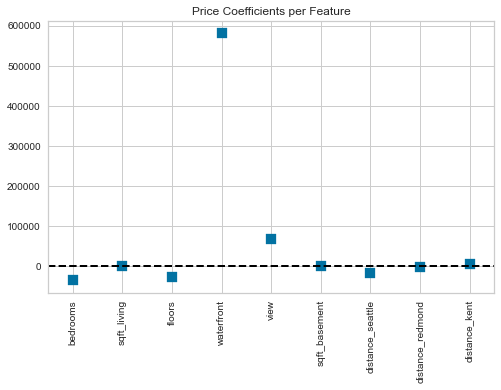

In [89]:
fig, ax = plt.subplots(figsize=(8, 5))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none',
              legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Price Coefficients per Feature')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=120, 
           y=coef_df['coef'], cmap='blue')
ax.axhline(y=0, linestyle='--', color='black', linewidth=2)
ax.xaxis.set_ticks_position('bottom')

In [ ]:
def clean_data_model_5(df):
    df.drop(['condition', 'sqft_lot', 'yr_renovated', 'bathrooms', 'recent_build'], axis=1, inplace=True)
    df = df[df['price'] < 4000000]
    df = df[df['sqft_basement'] < 3000]
    
    return df

In [ ]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_5 = clean_data_model_5(to_clean)

y_test = cleaned_X_test_5['price']
X_test = cleaned_X_test_5.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms_5 = mean_squared_error(y_test, y_prediction, squared=False)
rms_5

In [ ]:
r_squared_5 = model_5.rsquared
r_squared_5

In [ ]:
LR.score(X_test, y_test) #r-squared of test data

In [ ]:
df_6 = df_5.copy()

In [ ]:
# features = np.array([bedrooms, sqft_living, floors, waterfront, view, sqft_basement, distance_seattle, distance_redmond], dtype=float)

features = np.array([3, 1510, 1, 0, 0, 650, 6.3, 9.6, 2], dtype=float)

formula = LR.intercept_ + (np.dot(LR.coef_, features))
formula

In [ ]:
model_coefficients = pd.DataFrame(model_5.params[1:], columns=['coefficients'])
print("Final Regression Formula\n")
print(LR.intercept_, '+')
print('sum(')
for i in range(len(model_coefficients)):
    print(model_coefficients.coefficients[i], '*', model_coefficients.index[i])
print(')')


In [ ]:
def model_diagnostic(model, x, x_name, y):
    
    residuals = model.resid
    
    f = plt.figure()
    f, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey = False, figsize=(65,20), squeeze=False)
    
    f.text(s="Model Diagnostic Summary", x=.40, y=1.15, fontsize=65, fontname='silom')
    f.text(s="r-Squared: {r}".format(r=round(model.rsquared, 2)), x=.40, y=1.05, fontsize=50, fontname='serif')
    f.text(s="p-value: {p}".format(p= model.f_pvalue), x=.53, y=1.05, fontsize=50, fontname='serif')
    
    f.text(s='Residuals Histogram', x=.45, y=.93, fontsize=55, fontname='serif')
    
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax=axes[0][0])    
    plt.show;
    
    f.text(s='QQ Plot', x=.20, y=.93, fontsize=55, fontname='serif')
    
    axes[0][1].hist(residuals)
    plt.show;
    
    sns.residplot(x, y, ax=axes[0][2])
    
 
    f.text(s='Residuals vs {x}'.format(x=x_name), x=.73, y=.93, fontsize=55, fontname='serif')
    plt.tight_layout;
    plt.show;

In [ ]:
sns.boxplot(x=df['waterfront'], y=df['price'])

# MODEL 6 - Transformations

In [ ]:
df_6['log_sqft_living'] = np.log(df_6['sqft_living'])

In [ ]:
df_6.drop(['floors'], axis=1, inplace=True)

In [ ]:
df_6['area'] = df_6['bedrooms'] * df_6['sqft_living'] * df_6['sqft_basement']

In [ ]:
df_6['multi_dist'] = df_6['distance_seattle'] * df_6['distance_redmond'] * df_6['distance_kent']

## Model 6

In [ ]:
X = df_6.drop('price', axis=1)
y = np.log(df_6['price'])
model_6 = sm.OLS(y, sm.add_constant(X)).fit()
model_6.summary()

In [ ]:
def clean_data_model_6(df):
    df['log_sqft_living'] = np.log(df['sqft_living'])
    df.drop(['floors'], axis=1, inplace=True)
    df['area'] = df['bedrooms'] * df['sqft_living'] * df['sqft_basement']
    df['multi_dist'] = df['distance_seattle'] * df['distance_redmond'] * df['distance_kent']
    
    return df

In [ ]:
LR = LinearRegression()
LR.fit(X,y)

to_clean = X_test
to_clean['price'] = y_test

# Clean test according to cahnges so far
cleaned_X_test_6 = clean_data_model_6(to_clean)

y_test = cleaned_X_test_6['price']
X_test = cleaned_X_test_6.drop('price', axis=1)

y_prediction =  LR.predict(X_test)
y_prediction

rms_6 = mean_squared_error(y_test, y_prediction, squared=False)
rms_6

In [ ]:
r_squared_6 = model_6.rsquared
r_squared_6

In [ ]:
LR.score(X_test, y_test) #r-squared of test data

# Reassessing Linear Regression Assumptions

In [ ]:
sns.regplot(y_test, y_prediction);

In [ ]:
sns.distplot(model_6.resid);

In [ ]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model_6.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(model_6.predict(), model_6.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity');

The transformed data generates a model that looks much more fit for performing linear regressions. It's residual distribution looks not too far from normal, and confirmed by the improved quatile plot, and the residual look much more homoscedastic than they did at the beginning.

# Visualizations for Presentation

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
plt.title('Home Location vs. Price', fontsize=30)
sns.scatterplot(df['long'], df['lat'], hue=df_5['price'])

plt.xlabel('Longitude', fontsize=30)
plt.ylabel('Latitude', fontsize=30)
plt.legend([280,362,450,565,750,1000])
ax.plot(-122.3321, 47.6062, 'ro')
ax.plot(-122.1215, 47.6740, 'bo')
ax.plot(-122.2348, 47.3809, 'go')
ax.set_xlim(-122.45, -121.80)
ax.set_ylim(47.25, 47.80)
plt.legend(['Seattle', 'Redmond', 'Kent', 280,362,450,565,750,1000])
# plt.savefig('loc_price_2', bbox_inches='tight')
plt.tight_layout();

In [ ]:
dist_kent = df_5[df_5['distance_kent'] <= 1.5].sort_values(by='price', ascending=False)
dist_redmond = df_5[df_5['distance_redmond'] <= 1.5].sort_values(by='price', ascending=False)
dist_seattle = df_5[df_5['distance_seattle'] <= 1.5].sort_values(by='price', ascending=False)

fig = plt.figure()
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharex=False, sharey=True, figsize=(20,10), squeeze=False)

sns.boxplot(y="price", data=dist_redmond, ax=axes[0][0], linewidth=2.5, color="#7FBA00", showfliers=False)
sns.boxplot(y="price", data=dist_seattle, ax=axes[0][1], linewidth=2.5, color="r", showfliers=False)
sns.boxplot(y="price", data=dist_kent, ax=axes[0][2], linewidth=2.5, color="#1277e1", showfliers=False)

axes[0][0].set_ylabel('Price ($)', fontsize=20)
axes[0][1].set_ylabel('')
axes[0][2].set_ylabel('')
axes[0][0].set_xlabel('Redmond', fontsize=20)
axes[0][1].set_xlabel('Seattle', fontsize=20)
axes[0][2].set_xlabel('Kent', fontsize=20)
axes[0][1].set_title('Range of House Prices\n within 1.5 miles From Each City', fontsize=20);

# plt.savefig('price_dist_1', bbox_inches='tight');

In [ ]:
r_squares = [r_squared_1, r_squared_2, r_squared_3, r_squared_4, r_squared_5, r_squared_6]

fig, ax = plt.subplots(figsize=(16, 10))

ax = sns.barplot([1,2,3,4,5,6], r_squares, palette="Blues_d")
ax.set_ylim(0.5, .8)

;

In [ ]:
rms_lst = [rms_1, rms_2, rms_3, rms_4, rms_5]
rms_lst

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))

ax = sns.barplot([1,2,3,4,5], rms_lst, palette="Blues_d")
ax.set_ylim(170000, 220000);

In [ ]:
sns.violinplot(x=df_5['view'], y=df_5['price'], scale='width')

In [ ]:
sns.boxenplot(x="waterfront", y="price", data=df_5)

In [ ]:
sns.catplot(x="view", y="price",
                hue="waterfront",
                data=df_5, kind="violin", scale='width', split=True)

In [ ]:
sns.catplot(x="view", y="price", hue="waterfront", kind='bar', data=df_5)

In [ ]:
fig, ax = plt.subplots()



In [ ]:
bububu

###### 

In [ ]:
# def clean_data_model_6(df):
#     df['price'] = np.log(df['price'])

#     return df

In [ ]:
# LR = LinearRegression()
# LR.fit(X,y)

# to_clean = X_test
# to_clean['price'] = y_test

# # Clean test according to cahnges so far
# cleaned_X_test_6 = clean_data_model_6(to_clean)

# y_test = cleaned_X_test_6['price']
# X_test = cleaned_X_test_6.drop('price', axis=1)

# y_prediction =  LR.predict(X_test)
# y_prediction

# rms = mean_squared_error(y_test, y_prediction, squared=False)
# rms

In [ ]:
df_6['log_sqft_living'] = np.log(df_6['sqft_living'])

In [ ]:
f = 'price~sqft_living'
sqft_living_model = smf.ols(formula=f, data=df_6).fit()
residuals = sqft_living_model.resid
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(sqft_living_model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout();

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(sqft_living_model.predict(), sqft_living_model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity');

In [ ]:
sns.distplot(sqft_living_model.resid);

In [ ]:
f = 'price~bedrooms'
bedrooms_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(bedrooms_model, df_6['bedrooms'], 'bedrooms', df_6['price'])

In [ ]:
f = 'price~bedrooms'
bathrooms_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(bathrooms_model, df_6['bedrooms'], 'bedrooms', df_6['price'])

In [ ]:
f = 'price~sqft_living'
sqft_living_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(sqft_living_model, df_6['sqft_living'], 'sqft_living', df_6['price'])

In [ ]:
f = 'price~floors'
floors_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(floors_model, df_6['floors'], 'floors', df_6['price'])

In [ ]:
f = 'price~waterfront'
waterfront_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(waterfront_model, df_6['waterfront'], 'waterfront', df_6['price'])

In [ ]:
f = 'price~sqft_basement'
sqft_basement_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(sqft_basement_model, df_6['sqft_basement'], 'sqft_basement', df_6['price'])

In [ ]:
f = 'price~distance_seattle'
distance_seattle_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(distance_seattle_model, df_6['distance_seattle'], 'distance_seattle', df_6['price'])

In [ ]:
f = 'price~distance_redmond'
distance_redmond_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(distance_redmond_model, df_6['distance_redmond'], 'distance_redmond', df_6['price'])

In [ ]:
f = 'price~distance_kent'
distance_redmond_model = smf.ols(formula=f, data=df_6).fit()
model_diagnostic(distance_redmond_model, df_6['distance_kent'], 'distance_kent', df_6['price'])

In [ ]:
X = df.drop('price', axis=1)
y = df['price']
model = sm.OLS(y, sm.add_constant(X)).fit()
model.summary()

In [ ]:
sns.distplot(model_5.resid);

In [ ]:
fig = sm.graphics.qqplot(model_5.resid, dist=stats.norm, line='45', fit=True)

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(model.predict(), model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Checking for Homoscedasticity')

## Validating the Model

We fail to reject the null hypotesis here since the p-value is insignificant, so the model is homoscedastic.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':20}, pad=16);

## Checking Assumptions for Linear Regression

## sns.pairplot(df, y_vars=['price'])

In [ ]:
plt.scatter(x=df['sqft_living']**2, y=df['price'])

In [ ]:
df['sqft_living']**2

In [ ]:
# X = df.drop('price', axis=1)
for col in X.columns:
    plt.subplots(1, 1)
    sns.regplot(X[col], df.price)
    plt.title(col)